In [4]:
import pandas as pd
from astropy.convolution import Gaussian2DKernel
from astropy.table import Table, Column, setdiff, join, unique

from utils import *
from modeling import *
from plotting import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
read = False
save = True

## Measurement

mu: 460.20 , std: 4.17 , ZP: 27.10 , pix_scale: 2.50


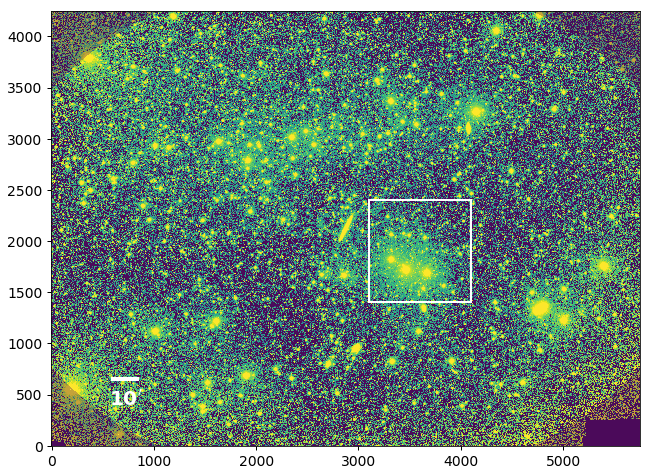

In [40]:
############################################
# Read 
############################################

R_scale = 10
obj_name = 'NGC5907-G'
band = 'G'
 
hdu = fits.open("./data/coadd_Sloan%s_NGC_5907.fits"%band)[0]
data = hdu.data
header = hdu.header
wcs_data = wcs.WCS(header)

seeing = 2.5
# Runned from create_photometric_light_APASS 
seg_map = fits.open("./SE_APASS/coadd_Sloan%s_NGC_5907_seg.fits"%band)[0].data
weight_edge = fits.open("./weight_NGC5907.fits")[0].data
SE_cat_full = Table.read("./SE_APASS/coadd_Sloan%s_NGC_5907.cat"%band,
                         format="ascii.sextractor")

mu, std = np.float(hdu.header["BACKVAL"]), mad_std(hdu.data[seg_map==0&(weight_edge>0.5)]) 
ZP, pix_scale = np.float(hdu.header["REFZP"]), np.float(hdu.header["PIXSCALE"])
print("mu: %.2f , std: %.2f , ZP: %.2f , pix_scale: %.2f" %(mu, std, ZP, pix_scale))

SE_cat_full["RMAG_AUTO"] = -2.5*np.log10(SE_cat_full["FLUX_AUTO"]) + ZP

############################################
# Crop
############################################
# patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (800, 1800, 1800, 2800)
# patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (2400, 1500, 3400, 2500)
patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax = (3100, 1400, 4100, 2400)
image_bounds = (patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax)
        
patch, seg_patch = crop_image(data, image_bounds, weight_map=weight_edge, SE_seg_map=seg_map, 
                              sky_mean=mu, sky_std=std, color="w",draw=True)

if read:
    table_res_Rnorm = Table.read("./%s-Rnorm_%dpix_15mag_X%dY%d.txt"\
                                 %(obj_name, R_scale, patch_Xmin, patch_Ymin), format="ascii")
    table_res_Rnorm = crop_catalog(table_res_Rnorm, bounds=image_bounds)

In [41]:
############################################
# Crossmatch
############################################

result = query_vizier(catalog_name="URAT", radius=2*u.deg, header=header,
                      columns=['RAJ2000', 'DEJ2000', 'mfa', 'gmag', 'e_gmag', 'rmag', 'e_rmag'],
                      column_filters={'mfa':'=1', 'rmag':'{0} .. {1}'.format(8, 18)})

Cat_URAT = result['I/329/urat1']
Cat_URAT = transform_coords2pixel(Cat_URAT, wcs_data, cat_name="URAT")     
print("URAT Brightest Star: %.3f"%Cat_URAT["rmag"].min())
    
result = query_vizier(catalog_name="USNO", radius=2*u.deg, header=header,
                      columns=['RAJ2000', 'DEJ2000', "Bmag","Rmag"],
                      column_filters={"Rmag":'{0} .. {1}'.format(5, 15)})

Cat_USNO = result['I/252/out']
Cat_USNO = transform_coords2pixel(Cat_USNO, wcs_data, cat_name="USNO")
print("USNO Brightest Star: %.3f"%Cat_USNO["Rmag"].min())

############################################
# Merge Catalog
############################################

df_match_URAT = merge_catalog(SE_cat_full, Cat_URAT, sep=2.5*u.arcsec, 
                              keep_columns=["NUMBER","X_IMAGE","Y_IMAGE","ELLIPTICITY","RMAG_AUTO", 'FWHM_IMAGE',
                                            "ID_URAT","X_IMAGE_URAT","Y_IMAGE_URAT","rmag","gmag","FLAGS"])
df_match_USNO = merge_catalog(SE_cat_full, Cat_USNO, sep=5*u.arcsec,
                               keep_columns=["NUMBER","X_IMAGE","Y_IMAGE","ELLIPTICITY","RMAG_AUTO",
                                             "ID_USNO","X_IMAGE_USNO","Y_IMAGE_USNO","Rmag","FLAGS"])

df_SE_match_all = pd.merge(df_match_URAT, df_match_USNO, how='outer')

bounds = (patch_Xmin-200, patch_Ymin-200, patch_Xmax+200, patch_Ymax+200)
df_SE_match = crop_catalog(df_SE_match_all, bounds, keys=("X_IMAGE", "Y_IMAGE"))
df_SE_match = df_SE_match.reset_index(drop=True)

target = df_SE_match["RMAG_AUTO"] < 15
df_SE_target = df_SE_match[target].reset_index().sort_values(by='RMAG_AUTO')
df_SE_target[:10]

URAT Brightest Star: 10.021
USNO Brightest Star: 7.000


,index,NUMBER,X_IMAGE,Y_IMAGE,ELLIPTICITY,FWHM_IMAGE,FLAGS,RMAG_AUTO,ID_URAT,gmag,rmag,X_IMAGE_URAT,Y_IMAGE_URAT,ID_USNO,Rmag,X_IMAGE_USNO,Y_IMAGE_USNO
161,408,19063,3466.0796,1721.5258,0.038,NaN,6,10.085964,NaN,NaN,NaN,NaN,NaN,1250.0,7.5,3465.5764,1721.5027
162,409,19617,3670.7646,1693.4302,0.124,NaN,6,10.290833,NaN,NaN,NaN,NaN,NaN,1104.0,7.9,3670.3911,1693.3785
160,407,18466,3321.3972,1824.0864,0.026,NaN,4,10.634559,NaN,NaN,NaN,NaN,NaN,1353.0,8.1,3321.5718,1824.3664
115,289,20822,3834.8767,1565.9124,0.084,3.93,4,11.605526,1983.0,10.587,10.217,3834.7529,1565.8076,1005.0,10.5,3834.3553,1565.6203
158,404,16517,3497.1108,2059.6765,0.249,NaN,4,11.617121,NaN,NaN,NaN,NaN,NaN,1231.0,10.4,3496.8658,2059.7309
60,154,16430,3322.2563,2066.9353,0.099,4.17,4,11.628150,2069.0,10.538,10.081,3322.1940,2066.9755,1346.0,10.5,3322.2546,2066.8534
120,301,21048,3634.0322,1540.8929,0.053,3.82,6,11.704921,1923.0,10.697,10.345,3633.9033,1540.7717,1135.0,10.1,3633.0452,1539.7426
64,164,16683,3652.0815,2038.4492,0.068,4.03,4,11.761021,2072.0,10.820,10.603,3651.9218,2038.3686,1115.0,10.7,3652.0285,2038.4325
16,34,13180,4104.7012,2466.5503,0.128,3.64,4,11.908086,4564.0,11.170,10.810,4104.5922,2466.4966,805.0,10.8,4104.5928,2466.2198
124,313,21360,3926.0103,1503.4731,0.033,3.36,4,12.071099,1989.0,11.593,10.790,3925.9918,1503.3913,952.0,10.8,3925.3294,1503.2865


In [42]:
############################################
# Crossmatch
############################################

result = query_vizier(catalog_name="Pan-STARRS", radius=2*u.deg, header=header,
                      columns=['RAJ2000', 'DEJ2000', 'mfa', 'gmag', 'e_gmag', 'rmag', 'e_rmag'],
                      column_filters={'rmag':'{0} .. {1}'.format(5, 18)})

Cat_PS = result['II/349/ps1']
Cat_PS = transform_coords2pixel(Cat_PS, wcs_data, cat_name="PS")     
print("Pan-STARRS Brightest Star: %.3f"%Cat_PS["rmag"].min())

############################################
# Merge Catalog
############################################

df_match_PS = merge_catalog(SE_cat_full, Cat_PS, sep=2.5*u.arcsec, 
                              keep_columns=["NUMBER","X_IMAGE","Y_IMAGE","ELLIPTICITY","RMAG_AUTO", 'FWHM_IMAGE',
                                            "ID_PS","X_IMAGE_PS","Y_IMAGE_PS","rmag","gmag","FLAGS"])

df_SE_match_all = df_match_PS.copy()

bounds = (patch_Xmin-200, patch_Ymin-200, patch_Xmax+200, patch_Ymax+200)
df_SE_match = crop_catalog(df_SE_match_all, bounds, keys=("X_IMAGE", "Y_IMAGE"))
df_SE_match = df_SE_match.reset_index(drop=True)

target = df_SE_match["RMAG_AUTO"] < 15
df_SE_target = df_SE_match[target].reset_index().sort_values(by='RMAG_AUTO')
df_SE_target[:10]

Pan-STARRS Brightest Star: 6.675


,index,NUMBER,X_IMAGE,Y_IMAGE,ELLIPTICITY,FWHM_IMAGE,FLAGS,RMAG_AUTO,ID_PS,gmag,rmag,X_IMAGE_PS,Y_IMAGE_PS
103,521,19063,3466.0796,1721.5258,0.038,7.07,6,10.085964,4748,7.7540,6.6749,3466.0151,1721.6087
110,556,19617,3670.7646,1693.4302,0.124,6.63,6,10.290833,5017,7.8390,7.9680,3670.3764,1693.3941
96,487,18466,3321.3972,1824.0864,0.026,5.57,4,10.634559,4769,7.9324,8.6055,3321.2541,1824.2012
125,635,20822,3834.8767,1565.9124,0.084,3.93,4,11.605526,4859,10.4674,10.4994,3834.8505,1565.9065
63,347,16430,3322.2563,2066.9353,0.099,4.17,4,11.628150,5095,10.6110,10.2440,3322.3262,2066.8430
130,657,21048,3634.0322,1540.8929,0.053,3.82,6,11.704921,4688,11.6498,10.4833,3634.1619,1540.8524
67,362,16683,3652.0815,2038.4492,0.068,4.03,4,11.761021,5112,11.1040,10.8710,3651.9928,2038.4448
16,79,13180,4104.7012,2466.5503,0.128,3.64,4,11.908086,11178,11.4060,11.0500,4104.6002,2466.4557
134,679,21360,3926.0103,1503.4731,0.033,3.36,4,12.071099,4875,12.1714,10.7379,3925.8890,1503.9096
19,93,13399,3989.4470,2442.8853,0.021,3.39,4,12.092144,11170,11.8450,11.3400,3989.5041,2443.1092


In [8]:
# ############################################
# # Measure
# ############################################

# def get_star_pos(id, star_cat, ref_pos=(0,0)):
#     X_c, Y_c = star_cat[id]["X_IMAGE"]-ref_pos[0], star_cat[id]["Y_IMAGE"]-ref_pos[1]
#     return (X_c, Y_c)

# def get_star_thumb(id, star_cat, data=data, seg_map=seg_map, 
#                    n_win=20, ref_pos=(0,0), seeing=2.5, w=wcs_data, verbose=True):
#     (X_c, Y_c) = get_star_pos(id, star_cat, ref_pos=ref_pos)    
    
#     fwhm =  max(star_cat[id]["FWHM_IMAGE"], seeing)
#     win_size = int( n_win * min(max(fwhm,2), 8))
    
#     X_min, X_max = X_c - win_size, X_c + win_size
#     Y_min, Y_max = Y_c - win_size, Y_c + win_size
#     x_min, y_min = coord_Im2Array(X_min, Y_min)
#     x_max, y_max = coord_Im2Array(X_max, Y_max)
    
#     if verbose:
#         num = star_cat[id]["NUMBER"]
#         print("NUMBER: ",num)
#         print("X_c, Y_c: ", (X_c, Y_c))
#         print("x_min, x_max, y_min, y_max: ", x_min, x_max, y_min, y_max)
    
#     img_thumb = data[ref_pos[0]+x_min:ref_pos[0]+x_max, ref_pos[1]+y_min:ref_pos[1]+y_max].copy()
#     seg_thumb = seg_map[ref_pos[0]+x_min:ref_pos[0]+x_max, ref_pos[1]+y_min:ref_pos[1]+y_max]
#     mask_thumb = (seg_thumb!=0)    
    
#     X_cen, Y_cen = w.wcs_world2pix(star_cat[id]["X_WORLD"], star_cat[id]["Y_WORLD"], 1)
#     cen_star = X_cen - (y_min+1), Y_cen - (x_min+1)
    
#     return img_thumb, seg_thumb, mask_thumb, cen_star
    
# def extract_star(id, star_cat, data=data, seg_map=seg_map, 
#                  seeing=2.5, sn_thre=2., n_win=20,
#                  display_bg=False, display=True, verbose=False):
    
#     img_thumb, seg_thumb, mask_thumb, cen_star = get_star_thumb(id, star_cat, data=data, seg_map=seg_map,
#                                                                 n_win=n_win, seeing=seeing, verbose=verbose)
#     fwhm = max([star_cat[id]["FWHM_IMAGE"], seeing])

#     b_size = round(img_thumb.shape[0]//5/25)*25
#     if img_thumb.shape[0] > 50:
#         back, back_rms = background_sub_SE(img_thumb, b_size=b_size)
#     else:
#         back, back_rms = (np.median(img_thumb[~mask_thumb])*np.ones_like(img_thumb), 
#                             mad_std(img_thumb[~mask_thumb])*np.ones_like(img_thumb))
#     if display_bg:
#             display_background_sub(img_thumb, back)        
            
#     # do segmentation (second time, target-based)
#     sigma = seeing * gaussian_fwhm_to_sigma
#     threshold = back + (sn_thre * back_rms)
#     segm = detect_sources(img_thumb, threshold, npixels=5)
    
#     # deblending
#     segm_deblend = deblend_sources(img_thumb, segm, npixels=5,
#                                    nlevels=64,
#                                    contrast=0.005)
#     star_lab = segm_deblend.data[img_thumb.shape[0]//2, img_thumb.shape[1]//2]
#     star_ma = ~((segm_deblend.data==star_lab) | (segm_deblend.data==0)) # mask other source
    
#     # display
#     if display:
#         fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1,ncols=4,figsize=(21,5))
#         ax1.imshow(img_thumb, vmin=np.median(back)-1, vmax=10000, norm=norm1, origin="lower", cmap="viridis")
#         ax1.set_title("star", fontsize=15)
#         ax2.imshow(segm, origin="lower", cmap=segm.make_cmap(random_state=12345))
#         ax2.set_title("segment", fontsize=15)
#         ax3.imshow(segm_deblend, origin="lower", cmap=segm_deblend.make_cmap(random_state=12345))
#         ax3.set_title("deblend", fontsize=15)

#         img_thumb_ma = img_thumb.copy()
#         img_thumb_ma[star_ma] = -1
#         ax4.imshow(img_thumb_ma, origin="lower", cmap="viridis", 
#                    vmin=np.median(back)-1, vmax=np.median(back)+10*np.median(back_rms), norm=norm2)
#         ax4.set_title("extracted star", fontsize=15)
    
#     return img_thumb, star_ma, back, cen_star

# def compute_Rnorm(image, mask_field, cen, R=8, wid=0.5, display=False):
#     """ Return sigma-clipped mean, med and std of ring r=R (half-width=wid) for image"""
#     annulus = CircularAnnulus(cen, R-wid, R+wid)
#     annulus_ma = annulus.to_mask()      
#     mask_ring = annulus_ma.to_image(image.shape)>0.5    # sky ring (R-wid, R+wid)
#     mask_clean = mask_ring & (~mask_field)            # sky ring with other sources masked
#     z_mean, z_med, z_std = sigma_clipped_stats(image[mask_clean], sigma=3)
    
#     if display:
#         plt.imshow(mask_clean*image, origin="lower", cmap="gray", norm=norm1, vmin=z_med-5*z_std, vmax=z_med+5*z_std)
    
#     return z_mean, z_med, z_std

# def compute_Rnorm_batch(tab_SE_target, SE_catalog=SE_cat_full, R=8, wid=0.5, return_full=False):
#     res_thumb = {}    
#     res_Rnorm = np.empty((len(tab_SE_target),4))
#     for i, (num, rmag_auto) in enumerate(zip(tab_SE_target['NUMBER'], tab_SE_target['RMAG_AUTO'])):
#         process_counter(i, len(tab_SE_target))

#         ind = num - 1
#         n_win = 30 if rmag_auto< 11 else 20
            
#         img, ma, bkg, cen = extract_star(ind, SE_cat_full, n_win=n_win, display_bg=False, display=False)
        
#         res_thumb[num] = {"image":img, "mask":ma, "bkg":bkg, "center":cen}
        
#         z_mean, z_med, z_std = compute_Rnorm(img, ma, cen, R=R, wid=wid)
#         sky_mean = np.median(bkg)
#         res_Rnorm[i] = np.array([z_mean, z_med, z_std, sky_mean])
#     return res_Rnorm, res_thumb

In [43]:
if read is False:
    res_Rnorm, res_thumb = compute_Rnorm_batch(df_SE_target, SE_cat_full, wcs_data, data, seg_map, 
                                               R=R_scale, wid=0.5, return_full=True)

    save_thumbs(res_thumb, '%s-Thumb_15mag_X%sY%s'%(obj_name, patch_Xmin, patch_Ymin))
    
    table_res_Rnorm = Table(np.hstack([df_SE_target['NUMBER'].values[:, None],
                                       df_SE_target['X_IMAGE'].values[:, None],
                                       df_SE_target['Y_IMAGE'].values[:, None], res_Rnorm]), 
                         names=['NUMBER','X_IMAGE','Y_IMAGE','mean','med','std','sky'], dtype=['int']+['float']*6)
    if save:
        table_res_Rnorm.write('%s-Rnorm_%dpix_15mag_X%sY%s.txt'\
                              %(obj_name, R_scale, patch_Xmin, patch_Ymin), overwrite=True, format='ascii')

completed: 33/165
completed: 66/165
completed: 99/165
completed: 132/165
completed: 165/165
Save thumbs to: NGC5907-G-Thumb_15mag_X3100Y1400


## Plotting

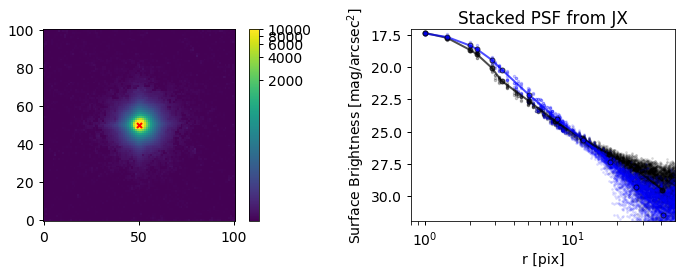

In [48]:
hdu = fits.open("./med_psf_JX.fits")[0]
hdu_p = fits.open("./median_psf_patch.fits")[0]
PSF_JX = hdu.data * 10 + mu
PSF_JX_p = hdu_p.data * 1e5 + mu

fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
im = ax1.imshow(PSF_JX_p, vmin=mu, vmax=10000, norm=norm1, aspect="equal", origin="lower", cmap="viridis")
ax1.plot(50,50,"rx",ms=5,mew=2)
colorbar(im)

ax2 = plt.subplot(122)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX, cen=(50,50),
                                             ZP=ZP, sky_mean=mu, sky_std=1, pix_scale=pix_scale,
                                             xunit="pix", yunit="SB", color="k",
                                             scatter=True, core_undersample=True)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(PSF_JX_p, cen=(50,50),
                                             ZP=ZP, sky_mean=mu, sky_std=1, pix_scale=pix_scale,
                                             xunit="pix", yunit="SB", color="b",
                                             scatter=True, core_undersample=True)
plt.ylim(32,17)
plt.title("Stacked PSF from JX")
plt.tight_layout()

In [44]:
import random
colour = [ "indianred", "steelblue", "seagreen", "gold", "lightcyan", "orchid", "orange", "gray", "brown" ]
random.seed(88)
rand_colours = [random.choice(colour) for i in range(len(df_SE_target))]

r = np.logspace(0.03,2.5,100)

def plot_fit_res_SB(res, r=r, mags=[15,12,9]):
    pmed, pmean, pcov = get_params_fit(res)
    print("Fit results: ", pmed)

    # PSF Parameters
    n_fit = pmed[1]                     # true power index
    f_fit = 10**pmed[0]                 # fraction of power law component
    theta_t = 5.
    theta_t_pix = theta_t / pix_scale 

    beta_psf = 10
    fwhm = 2.28 * pix_scale                         # moffat fwhm, in arcsec

    gamma = fwhm / 2. / np.sqrt(2**(1./beta_psf)-1)  # moffat core width, in arcsec
    gamma_pix = gamma / pix_scale  

    c_mof2Dto1D =  C_mof2Dto1D(gamma_pix, beta_psf)
    c_pow2Dto1D = C_pow2Dto1D(n_fit, theta_t_pix)

    I_A, I_B, I_C = [10**((mag-ZP)/-2.5) for mag in mags]
    comp1 = moffat1d_normed(r, gamma=gamma_pix, alpha=beta_psf) / c_mof2Dto1D 
    comp2 = trunc_power1d_normed(r, n_fit, theta_t_pix) / c_pow2Dto1D

    [I_tot_A, I_tot_B, I_tot_C] = [Intensity2SB(((1-f_fit) * comp1 + comp2 * f_fit) * I, 0, ZP, pix_scale)
                                      for I in [I_A, I_B, I_C]]
    return I_tot_A, I_tot_B, I_tot_C

In [51]:
def plot_PSF(fit_res, res_thumb, r_core=12,
             plot_stars=True, plot_stack=None, color='r', **kwargs):
    I_tot_A, I_tot_B, I_tot_C = plot_fit_res_SB(fit_res, **kwargs)
    
    if read:
        z_mean_s, z_med_s = table_res_Rnorm['mean'],table_res_Rnorm['med'] 
        z_std_s, sky_mean_s = table_res_Rnorm['std'],table_res_Rnorm['sky']

    else:
        z_mean_s, z_med_s, z_std_s, sky_mean_s = res_Rnorm.T

    plt.figure(figsize=(10,8))
    for num, rmag, sky_m, c in zip(df_SE_target["NUMBER"],df_SE_target["RMAG_AUTO"], sky_mean_s, rand_colours):
        img, ma, cen = res_thumb[num]['image'], res_thumb[num]['mask'], res_thumb[num]['center']
        alpha = min(0.1*(16-rmag), 0.7) 
        r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img, cen=cen, mask=ma, 
                                                     ZP=ZP, sky_mean=sky_m, sky_std=std,
                                                     xunit="pix", yunit="SB", color=c, lw=1, alpha=alpha)

    plt.fill_betweenx([32, 16.], x1=R_scale-0.5, x2=R_scale+0.5, color="gold", alpha=0.3)
    
    if plot_stars:
        for z_m, z_std, sky_m, c in zip(z_mean_s, z_std_s, sky_mean_s, rand_colours):
            plt.plot(R_scale, Intensity2SB(z_m, sky_m, ZP, pix_scale),"*", ms=10, color=c, alpha=0.5, zorder=3)
            
    if plot_stack is not None:
        r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(plot_stack, cen=(50,50), mask=None, 
                                                 ZP=ZP, sky_mean=mu, sky_std=2.5, pix_scale=pix_scale, dr=1,
                                                 xunit="pix", yunit="SB", color="k", lw=4, label="Stacked PSF (JX)",
                                                 core_undersample=True, plot_line=False)
    for k, I in enumerate([I_tot_C, I_tot_B, I_tot_A]):
        lab = "Fit (1D profile)" if k==0 else None
        plt.plot(r[r>12], I[r>12], color=color, ls="--", lw=3, label=lab, zorder=3, alpha=0.9)
    plt.axvspan(12, 24, color="steelblue",  alpha=0.1)
    plt.axvspan(24, 65, color="seagreen", alpha=0.1)
    plt.axvspan(0.8, 12, color="gray", alpha=0.2, label="Mask")
    
    plt.legend(fontsize=14)
    plt.ylim(32,17.)
    plt.xlim(1,220)

### Patch [800, 1800, 800, 2800] stars < 15 mag

In [26]:
fit_res1 = open_nested_fitting_result(filename='./real/fit_real_best_X800Y1800.res')
res_thumb1 = load_thumbs('%s-Thumb_15mag_X800Y1800'%obj_name)

In [27]:
plot_PSF(fit_res1, res_thumb1)

### R-band Patch [3100, 1400, 4100, 2400]  containing brighter stars

In [28]:
fit_res1 = open_nested_fitting_result(filename='./real/fit_real_best_X3100Y1400.res')
res_thumb1 = load_thumbs('%s-Thumb_15mag_X3100Y1400'%obj_name)

Read thumbs from: NGC_5907-R-Thumb_15mag_X3100Y1400


Fit results:  [-6.50495723e-01  3.37575243e+00  8.86088254e+02  2.99072081e+00]


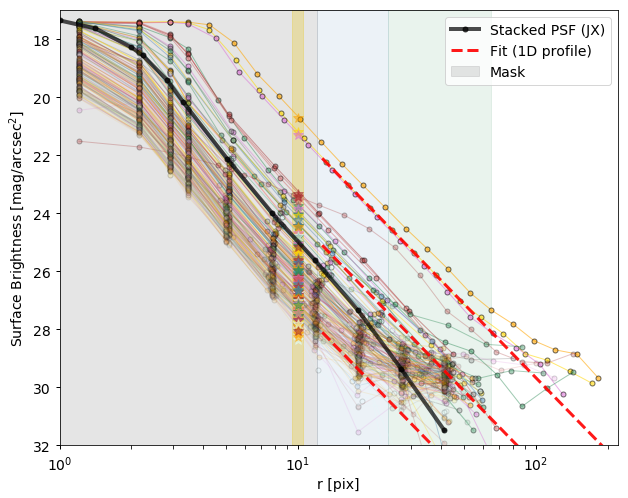

In [39]:
plot_PSF(fit_res1, res_thumb1, plot_stack=PSF_JX_p, mags=[14, 11, 8])

### G-band Patch [3100, 1400, 4100, 2400]  containing brighter stars

Read thumbs from: NGC5907-G-Thumb_15mag_X3100Y1400
Fit results:  [ -0.97171082   3.28641483 462.88711497   5.13372273]


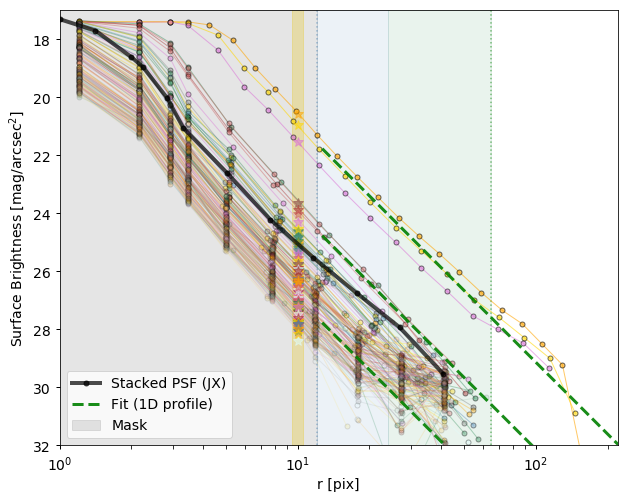

In [54]:
fit_res2 = open_nested_fitting_result(filename='NGC5907-G-fit_best_X3100Y1400.res')
fit_res2 = open_nested_fitting_result(filename='./NGC5907-G-fit_best_X3100Y1400.res')
res_thumb2 = load_thumbs('NGC5907-G-Thumb_15mag_X3100Y1400')
plot_PSF(fit_res2, res_thumb2,  plot_stack=PSF_JX, color='g', mags=[13,10,7])
plt.axvline(65, color="g", ls=":", alpha=0.5)
plt.axvline(12, color="steelblue", ls=":", alpha=0.5)

### Another patch [800, 600, 1800, 1600]  containing brighter stars (the same fit)

In [104]:
fit_res2 = open_nested_fitting_result(filename='./real/fit_real_best_X800Y600.res')

Fit results:  [-7.53674241e-01  3.37092177e+00  8.86120569e+02  3.44800822e+00]
